In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os 

In [64]:
def nose_steps():

    path = '../code/NOSE_results.json'

    # DIffernces
    # - addd 2 * x in hidden state
    # - using the avarege of 10 samples

    with open(path) as f:
        data = json.load(f)


    te_matrix = np.zeros((len(data.keys()), 32))

    for i, (key, value) in enumerate(data.items()):
        for j, (k, v) in enumerate(data[key]['transfer_entropy'].items()):
            te_matrix[i, int(k)] = v


    plt.figure(figsize=(15, 6))

    sns.lineplot(data=pd.DataFrame(te_matrix).T, dashes=True, linewidth=2)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Attention Layer Index') 
    plt.ylabel('Transfer Entropy')
    leg = plt.legend(title='Steps', loc='upper left', fontsize=13)
    leg._legend_box.align = "left"
    plt.title('Transfer Entropy between Attention Layers and last layer')


    plt.show()


def nose_summary():

    path = '../code/NOSE_results.json'

    with open(path) as f:
        data = json.load(f)

    num_layers = 32
    steps = list(data.keys())
    columns = np.arange(num_layers)

    matrix = np.zeros((len(steps), len(columns)))
    results_line = np.zeros(num_layers)

    for i, step in enumerate(steps):
        line = [data[step]['transfer_entropy'].get(str(col), np.nan) for col in columns]
        min_line, max_line = np.nanmin(line), np.nanmax(line)
        values = [(x - min_line) / (max_line - min_line) for x in line]
        matrix[i, :] = values

    for i, value in enumerate(matrix[-1, :]):
        if np.isnan(value) or value == 0:
            results_line[i] = np.nan
        else:
            results_line[i] = 0


    # Create the plot
    plt.figure(figsize=(15, 6))

    matrix = np.vstack((matrix, np.zeros(num_layers)))
    matrix = np.vstack((matrix, results_line))
    labels = [f'Step {i}' for i in range(len(data.keys()))] + ['', 'Result']

    cbar_kws=dict(pad=0.03, shrink=0.8)

    sns.heatmap(matrix, annot=False, cmap='YlGnBu', cbar=True, vmin=0, vmax=1, linewidths=1, cbar_kws=cbar_kws)
    plt.yticks(np.arange(len(steps)+2)+0.5, labels=labels, rotation=0)
    plt.tick_params(axis='x', which='both', top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.tick_params(axis='both', which='both', length=0)
    plt.tick_params(axis='y', which='both', length=0, pad=8)
    plt.title('Index of Attn Layer', loc='center', pad=30, size=11)



    for y in range(matrix.shape[1]):
        if matrix[-2, y] == 0:
            plt.gca().add_patch(plt.Rectangle((y, matrix.shape[0]-2), 1, 1, fill=True, color='white', linestyle='-', linewidth=1.5))

    for y in range(matrix.shape[1]):
        if matrix[-1, y] == 0:
            plt.gca().add_patch(plt.Rectangle((y, matrix.shape[0]-1), 1, 1, fill=True, edgecolor='white', linestyle='-', linewidth=1.5))

    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            if matrix[x, y] == 0 and x != matrix.shape[0] - 1 and x != matrix.shape[0] - 2:
                plt.gca().add_patch(plt.Rectangle((y, x), 1, 1, fill=False, edgecolor='red', linestyle='--', linewidth=1.5))
            if np.isnan(matrix[x, y]):
                plt.gca().add_patch(plt.Rectangle((y+0.06, x+0.05), .9, .9, fill=False, hatch='...', edgecolor='grey', linestyle='-', linewidth=0))

    plt.show()


def training_records():

    results_dir = '../code/training/results'

    folders = [f for f in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, f))]

    num_folders = len(folders)
    num_cols = 3  
    num_rows = (num_folders + num_cols - 1) // num_cols  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    axes = axes.flatten()

    for idx, folder in enumerate(folders):
        try:
            file_path = os.path.join(results_dir, folder, 'epochs_metrics.json')
            
            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    data = json.load(f)
                
                train_loss, val_loss = [], []
                
                for epoch in data:
                    epoch_results = data[epoch]
                    train_loss.append(epoch_results['train_loss'])
                    val_loss.append(epoch_results['val_loss'])
                
                ax = axes[idx]
                ax.plot(train_loss, label='train')
                ax.plot(val_loss, label='val')
                ax.set_ylim(0.2, 1)
                ax.set_title(f'Loss Metrics for {folder}')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend()
            else:
                print(f"Warning: File {file_path} not found. Skipping.")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    for idx in range(num_folders, num_rows * num_cols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


def results_df(reverse=False):
    columns = ['model', 'flops', 'parameters', 'memory', 'BLUE', 'CB', 'CA']
    columns_units = ['Model', 'Flops (B)', 'Parameters (B)', 'Memory (GB)', 'BLUE', 'CB', 'CA']
    df = pd.DataFrame(columns=columns)

    folders = os.listdir('../results')

    for i, folder in enumerate(folders):
        file_path = '../results/' + folder + '/metrics.json'
        with open(file_path, 'r') as f:
            data = json.load(f)
            data['model'] = folder
            df.loc[i] = data



    df['flops'] = df['flops'] / 1e9
    df['parameters'] = df['parameters'] / 1e9
    df['memory'] = df['memory'] / 1024**3


    df = df.map(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)
    df['flops'] = df['flops'].astype(int)

    baseline_row = df.loc[df['model'] == 'baseline']

    def add_percentage(value, row_name, col_name):
        if row_name != 0 and col_name != 'model':
            base_value = float(baseline_row[col_name])
            percentage_change = ((value - base_value) / base_value) * 100
            
            return f"{value} ({percentage_change:+.2f}%)"
        
        else:
            return value


    for col_name in df.columns:
        df[col_name] = df.apply(lambda row: add_percentage(row[col_name], row.name, col_name), axis=1)

    df.columns = columns_units

    if reverse:
        df = df[df['Model'].str.contains('baseline|reverse', na=False)]

    else:
        df = df[~df['Model'].str.contains('reverse', na=False)]

    df.set_index('Model', inplace=True)

    return df


def reverse_plot():
    columns = ['model', 'flops', 'parameters', 'memory', 'BLUE', 'CB', 'CA']
    df = pd.DataFrame(columns=columns)
    folders = os.listdir('../results')

    for i, folder in enumerate(folders):
        if 'reverse' in folder or 'baseline' in folder:
            file_path = '../results/' + folder + '/metrics.json'
            with open(file_path, 'r') as f:
                data = json.load(f)
                data['model'] = folder
                df.loc[i] = data

    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    xticks_labels = [0, 1, 2, 5, 10]

    # First subplot: Flops
    df.plot(x='model', y='flops', ax=axes[0, 0], marker='o', linestyle='-')
    axes[0, 0].set_title('Flops Comparison')
    axes[0, 0].set_xlabel('Number of removed layers')
    axes[0, 0].set_ylabel('Flops (B)')
    axes[0, 0].set_xticks(range(len(df)))
    axes[0, 0].set_xticklabels(xticks_labels)

    # Second subplot: Parameters
    df.plot(x='model', y='parameters', ax=axes[0, 1], marker='o', linestyle='-')
    axes[0, 1].set_title('Parameters Comparison')
    axes[0, 1].set_xlabel('Number of removed layers')
    axes[0, 1].set_ylabel('Parameters (B)')
    axes[0, 1].set_xticks(range(len(df)))
    axes[0, 1].set_xticklabels(xticks_labels)

    # Third subplot: Memory
    df.plot(x='model', y='memory', ax=axes[1, 0], marker='o', linestyle='-')
    axes[1, 0].set_title('Memory Comparison')
    axes[1, 0].set_xlabel('Number of removed layers')
    axes[1, 0].set_ylabel('Memory (GB)')
    axes[1, 0].set_xticks(range(len(df)))
    axes[1, 0].set_xticklabels(xticks_labels)

    # Fourth subplot: Last three columns
    last_three_columns = df.columns[-3:]
    for el in last_three_columns:
        df.plot(x='model', y=el, ax=axes[1, 1], label=el, marker='o', linestyle='-')
    axes[1, 1].set_title('Metrics Comparison')
    axes[1, 1].set_xlabel('Number of removed layers')
    axes[1, 1].set_ylabel('Values')
    axes[1, 1].set_xticks(range(len(df)))
    axes[1, 1].set_xticklabels(xticks_labels)
    axes[1, 1].legend(last_three_columns)

    plt.tight_layout()
    plt.show()

    return df

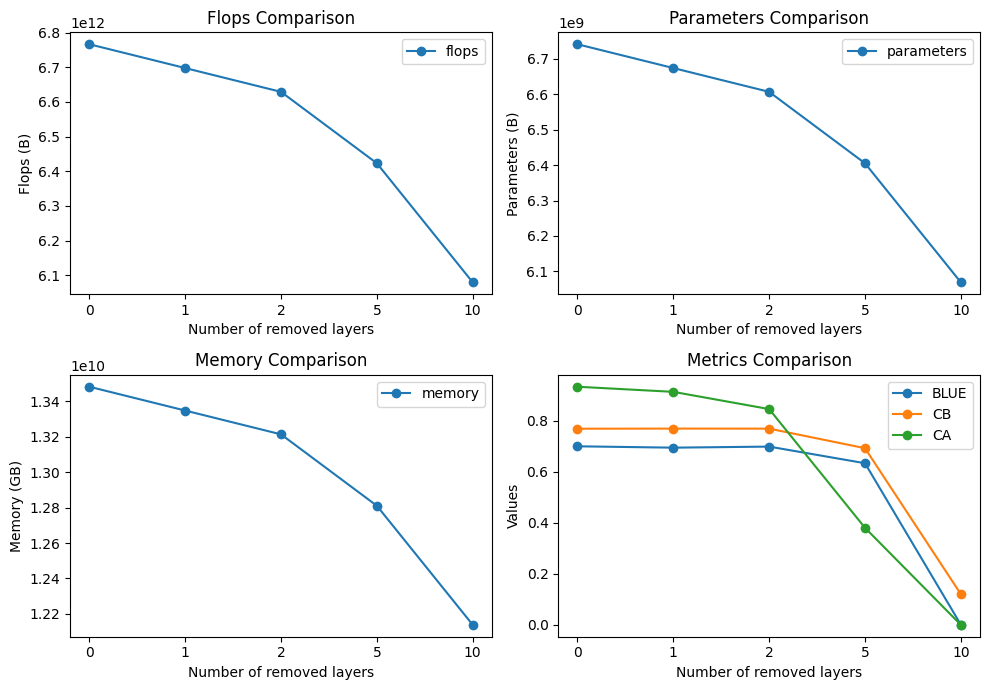

,model,flops,parameters,memory,BLUE,CB,CA
0,baseline,6766723072000,6740512768,13481041920,0.699208,0.768086,0.9325
6,nose_step_zero_shot_reverse_0,6698001563648,6673403904,13346824192,0.693865,0.768536,0.9125
7,nose_step_zero_shot_reverse_1,6629282086912,6606295040,13212605952,0.698048,0.768398,0.8450
8,nose_step_zero_shot_reverse_4,6423123656704,6404968448,12809951232,0.632916,0.691810,0.3800
9,nose_step_zero_shot_reverse_9,6079526273024,6069424128,12138860032,0.000545,0.120175,0.0000


In [65]:
reverse_plot()

In [ ]:
nose_steps()

In [ ]:
nose_summary()

In [ ]:
training_records()

In [12]:
results_df(False)

C:\Users\mcandi\AppData\Local\Temp\ipykernel_2324\3458781241.py:174: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_value = float(baseline_row[col_name])


,Flops (B),Parameters (B),Memory (GB),BLUE,CB,CA
Model,,,,,,
baseline,6766,6.74,12.56,0.7,0.77,0.93
nose_step_0,6698 (-1.01%),6.67 (-1.04%),12.43 (-1.04%),0.7 (+0.00%),0.76 (-1.30%),0.86 (-7.53%)
nose_step_4,6698 (-1.01%),6.67 (-1.04%),12.43 (-1.04%),0.6 (-14.29%),0.66 (-14.29%),0.52 (-44.09%)
nose_step_without_layernorm_4,6698 (-1.01%),6.67 (-1.04%),12.43 (-1.04%),0.59 (-15.71%),0.67 (-12.99%),0.49 (-47.31%)
nose_step_zero_shot_0,6698 (-1.01%),6.67 (-1.04%),12.43 (-1.04%),0.61 (-12.86%),0.58 (-24.68%),0.03 (-96.77%)
nose_step_zero_shot_4,6423 (-5.07%),6.4 (-5.04%),11.93 (-5.02%),0.0 (-100.00%),0.23 (-70.13%),0.0 (-100.00%)


In [62]:
results_df(True)

C:\Users\mcandi\AppData\Local\Temp\ipykernel_2324\3961249470.py:174: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_value = float(baseline_row[col_name])


,Flops (B),Parameters (B),Memory (GB),BLUE,CB,CA
Model,,,,,,
baseline,6766,6.74,12.56,0.7,0.77,0.93
nose_step_zero_shot_reverse_0,6698 (-1.01%),6.67 (-1.04%),12.43 (-1.04%),0.69 (-1.43%),0.77 (+0.00%),0.91 (-2.15%)
nose_step_zero_shot_reverse_1,6629 (-2.02%),6.61 (-1.93%),12.31 (-1.99%),0.7 (+0.00%),0.77 (+0.00%),0.84 (-9.68%)
nose_step_zero_shot_reverse_4,6423 (-5.07%),6.4 (-5.04%),11.93 (-5.02%),0.63 (-10.00%),0.69 (-10.39%),0.38 (-59.14%)
nose_step_zero_shot_reverse_9,6079 (-10.15%),6.07 (-9.94%),11.31 (-9.95%),0.0 (-100.00%),0.12 (-84.42%),0.0 (-100.00%)


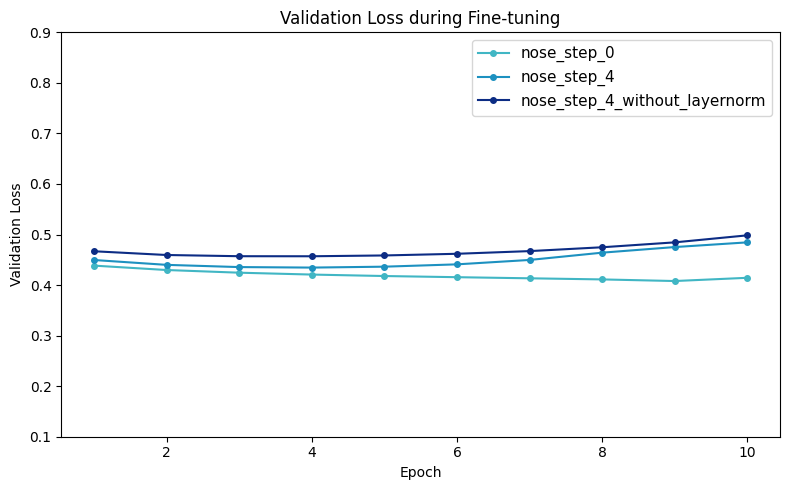

In [97]:
import json
import matplotlib.pyplot as plt
import glob

# Load all JSON files into a list
file_list = glob.glob('epochs_metrics_*.json')

# Set up the plot
plt.figure(figsize=(8, 5))
colors = ['#41b6c4', '#1d91c0', '#0c2c84']

# Plot validation loss for each file
for i, file_name in enumerate(file_list):
    with open(file_name, 'r') as f:
        data = json.load(f)

    epochs = range(1, len(data) + 1)
    val_losses = [data[f"epoch_{i}"]["val_loss"] for i in epochs]

    if 'without' in file_name:
        label = 'nose_step_' + file_name.split('.')[0][-1] + '_without_layernorm'
    else:
        label = 'nose_step_' + file_name.split('.')[0][-1]

    plt.plot(epochs, val_losses, marker='o', linestyle='-', label=label, markersize=4, color=colors[i])

# Set plot titles and labels
plt.title('Validation Loss during Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.ylim(0.1, 0.9)

# Add legend
plt.legend(fontsize=11)

# Show the plot
plt.tight_layout()
plt.show()
